In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/Biohackers/Hackaton/Dataset Binario'

In [3]:
# Cargar los arrays numpy desde los archivos .npy
train_images = np.load(f'{path}/training_set_bin/train_images_bin.npy')
train_labels = np.load(f'{path}/training_set_bin/train_labels_bin.npy')
val_images = np.load(f'{path}/val_set_bin/val_images_bin.npy')
val_labels = np.load(f'{path}/val_set_bin/val_labels_bin.npy')
test_images = np.load(f'{path}/test_set_bin/test_images_bin.npy')
test_labels = np.load(f'{path}/test_set_bin/test_labels_bin.npy')

In [11]:
def Convertir1(lista):
  for i in range(len(lista)):
    if(lista[i] == 4): lista[i] = 1
  return lista

In [36]:
train_labels = np.array(Convertir1(train_labels))
val_labels = np.array(Convertir1(val_labels))
test_labels = np.array(Convertir1(test_labels))

In [4]:
import numpy as np

def crop_image(image):
    """
    Recorta una imagen de 299x299 a 224x224 centrándola.

    Args:
    - image: numpy array. La imagen de entrada de dimensiones 299x299x3.

    Returns:
    - cropped_image: numpy array. La imagen recortada de dimensiones 224x224x3.
    """
    # Determina el área que deseas recortar
    start_x = (299 - 224) // 2  # Coordenada x de inicio para el recorte
    start_y = (299 - 224) // 2  # Coordenada y de inicio para el recorte
    end_x = start_x + 224  # Coordenada x de fin para el recorte
    end_y = start_y + 224  # Coordenada y de fin para el recorte

    # Recorta la imagen
    cropped_image = image[start_x:end_x, start_y:end_y, :]

    return cropped_image

train_resized = []
for i in range(len(train_images)):
  train_resized.append(crop_image(train_images[i]))


In [38]:
val_resized = []
for i in range(len(val_images)):
  val_resized.append(crop_image(val_images[i]))

In [12]:
test_resized = []
for i in range(len(test_images)):
  test_resized.append(crop_image(test_images[i]))

In [6]:
train_array = np.array(train_resized)
val_array = np.array(val_resized)
test_array = np.array(test_resized)

In [8]:
test_array[0].shape

(224, 224, 1)

## Modelo

In [76]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Combina tus datos de entrenamiento y validación en un solo conjunto de datos
# Convertir las matrices numpy en tensores de PyTorch
train_images_tensor = torch.tensor(train_array)
val_images_tensor = torch.tensor(val_array)
train_labels_tensor = torch.tensor(train_labels)
val_labels_tensor = torch.tensor(val_labels)

# Concatenar las imágenes para tener 3 canales
train_3_images = torch.cat([train_images_tensor] * 3, dim=3)
val_3_images = torch.cat([val_images_tensor] * 3, dim=3)

# Preparar los datos para DataLoader
train_data = []
for i in range(len(train_3_images)):
    image = train_3_images[i]
    train_data.append(image.permute(2, 0, 1))  # Permuta las dimensiones para tener el formato correcto (C x H x W)

val_data = []
for i in range(len(val_3_images)):
    image = val_3_images[i]
    val_data.append(image.permute(2, 0, 1))

# Stack los datos en tensores
train_tensor = torch.stack(train_data)
val_tensor = torch.stack(val_data)

# Verificar las dimensiones del tensor de entrenamiento y validación
print("Dimensiones del tensor de entrenamiento:", train_tensor.shape)
print("Dimensiones del tensor de validación:", val_tensor.shape)

# Crear el conjunto de datos utilizando TensorDataset
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

# Verificar las dimensiones del dataset de entrenamiento y validación
print("Longitud del dataset de entrenamiento:", len(train_dataset))
print("Longitud del dataset de validación:", len(val_dataset))

Dimensiones del tensor de entrenamiento: torch.Size([400, 3, 224, 224])
Dimensiones del tensor de validación: torch.Size([50, 3, 224, 224])
Longitud del dataset de entrenamiento: 400
Longitud del dataset de validación: 50


In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from sklearn.model_selection import KFold
import numpy as np

# Define los hiperparámetros
num_classes = 1
learning_rate = 0.01
batch_size = 32
num_epochs = 2
num_folds = 5  # Número de pliegues para la validación cruzada

# Supongamos que tienes tus datos train_dataset y val_dataset

# Inicializa el validador cruzado estratificado
skf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lista para almacenar las métricas de rendimiento en cada pliegue
validation_accuracies = []

# Realiza la validación cruzada
for fold, (train_idx, val_idx) in enumerate(skf.split(train_dataset, train_labels)):
    print(f'Fold {fold + 1}/{num_folds}')


    # Extraer datos y etiquetas de entrenamiento y validación para este pliegue
    X_train_fold, y_train_fold = train_dataset[train_idx]
    X_val_fold, y_val_fold = train_dataset[val_idx]

    # Crear DataLoader para los conjuntos de datos de entrenamiento y validación de este pliegue
    train_loader = DataLoader(TensorDataset(X_train_fold, y_train_fold), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_fold, y_val_fold), batch_size=batch_size, shuffle=False)

    # Crea una instancia del modelo VGG16 pre-entrenado
    vgg16 = models.vgg16(pretrained=True)

    # Congela los parámetros de todas las capas
    for param in vgg16.parameters():
        param.requires_grad = False

    # Modifica la última capa completamente conectada para adaptarse a tu problema de clasificación binaria
    vgg16.classifier[6] = nn.Linear(4096, num_classes)

    # Añadir dropout
    vgg16.classifier.add_module("7", nn.Dropout(p=0.5))  # Agregar dropout con probabilidad 0.5

    # Define la función de pérdida y el optimizador
    criterion = nn.BCELoss()
    optimizer = optim.Adam(vgg16.parameters(), lr=learning_rate, weight_decay=0.001)

    # Entrenamiento del modelo
    for epoch in range(num_epochs):
        vgg16.train()
        epoch_loss = 0.0
        for batch_data, batch_labels in train_loader:
            optimizer.zero_grad()
            batch_data = batch_data.to(torch.float32)
            outputs = vgg16(batch_data)
            outputs = torch.squeeze(outputs, dim=1)  # Eliminar la dimensión extra en la salida
            outputs = torch.sigmoid(outputs)  # Aplicar la función de activación sigmoid
            loss = criterion(outputs, batch_labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

    # Validación del modelo
    vgg16.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_data, batch_labels in val_loader:
            batch_data = batch_data.to(torch.float32)
            outputs = vgg16(batch_data)
            outputs = torch.squeeze(outputs, dim=1)  # Eliminar la dimensión extra en la salida
            outputs = torch.sigmoid(outputs)  # Aplicar la función de activación sigmoid
            predicted = (outputs > 0.5).float()  # Convertir las probabilidades a etiquetas (0 o 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
    validation_accuracy = correct / total
    validation_accuracies.append(validation_accuracy)
    print(f'Validation Accuracy: {validation_accuracy * 100:.2f}%')

# Calcula la precisión media de todos los pliegues
mean_validation_accuracy = np.mean(validation_accuracies)
print("Mean validation accuracy across all folds:", mean_validation_accuracy)


Fold 1/5
Epoch [1/2], Loss: 13.6158
Epoch [2/2], Loss: 9.8861
Validation Accuracy: 66.25%
Fold 2/5
Epoch [1/2], Loss: 18.9634
Epoch [2/2], Loss: 22.2454
Validation Accuracy: 47.50%
Fold 3/5
Epoch [1/2], Loss: 8.6994
Epoch [2/2], Loss: 8.2075
Validation Accuracy: 82.50%
Fold 4/5
Epoch [1/2], Loss: 14.1742
Epoch [2/2], Loss: 9.0075
Validation Accuracy: 67.50%
Fold 5/5
Epoch [1/2], Loss: 9.6271
Epoch [2/2], Loss: 9.6260
Validation Accuracy: 57.50%
Mean validation accuracy across all folds: 0.6425000000000001


In [85]:
# Guardar el modelo
torch.save(vgg16.state_dict(), f'{path}/modelo_binario_entrenado2.pth')

## Test

In [32]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Combina tus datos de entrenamiento y validación en un solo conjunto de datos
# Convertir las matrices numpy en tensores de PyTorch
test_images_tensor = torch.tensor(test_array)
test_labels_tensor = torch.tensor(test_labels)

# Concatenar las imágenes para tener 3 canales
test_3_images = torch.cat([test_images_tensor] * 3, dim=3)

# Preparar los datos para DataLoader
test_data = []
for i in range(len(test_3_images)):
    image = test_3_images[i]
    test_data.append(image.permute(2, 0, 1))  # Permuta las dimensiones para tener el formato correcto (C x H x W)
print(len(test_data))

# Stack los datos en tensores
test_tensor = torch.stack(test_data)
print(len(test_tensor))
# Verificar las dimensiones del tensor de entrenamiento y validación
print("Dimensiones del tensor de entrenamiento:", test_tensor.shape)

# Crear el conjunto de datos utilizando TensorDataset
test_dataset = TensorDataset(test_tensor, test_labels_tensor)

# Verificar las dimensiones del dataset de entrenamiento y validación
print("Longitud del dataset de entrenamiento:", len(test_dataset))

50
50
Dimensiones del tensor de entrenamiento: torch.Size([50, 3, 224, 224])
Longitud del dataset de entrenamiento: 50


In [83]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [91]:
(test_loader)

In [93]:
import torch
import torch.nn as nn
from torchvision import models

# Definir la arquitectura de la red
vgg16_modificada = models.vgg16(pretrained=False)
vgg16_modificada.classifier[6] = nn.Linear(4096, 1)  # Asegúrate de que num_classes sea igual al número de clases que tenías cuando entrenaste el modelo

# Cargar los pesos del modelo
vgg16_modificada.load_state_dict(torch.load(f'/content/drive/MyDrive/Biohackers/Hackaton/Dataset Binario/modelo_binario_entrenado2.pth'))
vgg16_modificada.eval()
# Evaluar el modelo en el conjunto de datos de prueba
correct = 0
total = 0
predictions = []
with torch.no_grad():
    for batch_data, batch_labels in test_loader:
        batch_data = batch_data.to(torch.float32)
        outputs = vgg16(batch_data)
        outputs = torch.squeeze(outputs, dim=1)
        outputs = torch.sigmoid(outputs)
        predicted = (outputs > 0.5).float()
        predictions.append(predicted)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Concatenar todas las predicciones y etiquetas
#predictions = torch.cat(predictions)
#test_labels = test_labels_tensor

# Calcular la precisión
#accuracy = (predictions == test_labels).float().mean()
#print(f'Precisión del modelo en los datos de prueba: {accuracy.item()*100:.2f}%')


Test Accuracy: 68.00%


In [94]:
predictions = torch.cat(predictions)


In [95]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Supongamos que 'y_true' son las etiquetas verdaderas y 'y_pred' son las etiquetas predichas por el modelo

# Ejemplo de etiquetas verdaderas y predichas
y_true = test_labels
y_pred = predictions

# Calcular la precisión
precision = precision_score(y_true, y_pred, average='macro')

# Calcular la exhaustividad
recall = recall_score(y_true, y_pred, average='macro')

# Calcular el valor-F1
f1 = f1_score(y_true, y_pred, average='macro')

# Calcular la precisión global (accuracy)
accuracy = accuracy_score(y_true, y_pred)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)


Precision: 0.8222222222222222
Recall: 0.6190476190476191
F1-score: 0.5841995841995842
Accuracy: 0.68
Confusion Matrix:
[[ 5 16]
 [ 0 29]]


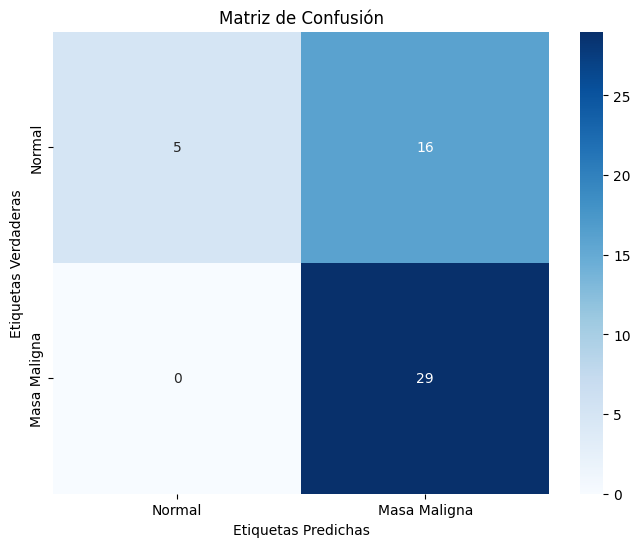

In [96]:
import seaborn as sns

# Definir etiquetas de las clases
labels = ['Normal', 'Masa Maligna']
#n, cb, mb, cm, mm
# Crear el mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')
plt.show()